In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import collections

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    confusion_matrix,
    classification_report
)

from tensorflow.python.platform import build_info as tf_build_info
from collections import Counter
print(tf_build_info.build_info)

from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers, regularizers, optimizers, callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np

OrderedDict([('is_cuda_build', False), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll')])


In [15]:
import pandas as pd
import numpy as np

def remove_non_integer_pitches(df, pitch_col="pitch", tolerance=1e-6, verbose=True):
    """
    Removes rows where the pitch value is not (approximately) a whole number.
    Keeps only rows where pitch is an integer (within rounding tolerance).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset containing the pitch column.
    pitch_col : str
        Column name representing roof pitch (default: "pitch").
    tolerance : float
        Allowed floating-point tolerance for rounding errors (default: 1e-6).
    verbose : bool
        Whether to print summary information.

    Returns
    -------
    pd.DataFrame
        Cleaned DataFrame with only whole-number pitch values retained.
    """

    if pitch_col not in df.columns:
        raise ValueError(f"❌ Column '{pitch_col}' not found in DataFrame.")

    before = len(df)
    df_clean = df[np.abs(df[pitch_col] - df[pitch_col].round()) < tolerance].copy()
    after = len(df_clean)
    removed = before - after

    if verbose:
        print(f"\n✅ Removed {removed:,} rows with non-integer pitches.")
        print(f"Remaining rows: {after:,}")
        print("Unique pitches kept:", sorted(df_clean[pitch_col].unique()))

    return df_clean


In [16]:
import pandas as pd

def remove_rare_spans(df, span_col="span_in", min_freq=10, verbose=True):
    """
    Removes all rows where the span value occurs fewer than `min_freq` times.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset containing a span column.
    span_col : str
        Column name containing span values (default='span_in').
    min_freq : int
        Minimum number of samples required to keep a span.
    verbose : bool
        Whether to print summary information.

    Returns
    -------
    pd.DataFrame
        DataFrame with rare spans removed.
    """
    if span_col not in df.columns:
        raise ValueError(f"❌ Column '{span_col}' not found in DataFrame.")

    # Count samples per span
    span_counts = df[span_col].value_counts()
    rare_spans = span_counts[span_counts < min_freq].index

    before = len(df)
    df_clean = df[~df[span_col].isin(rare_spans)].copy()
    after = len(df_clean)
    removed = before - after

    if verbose:
        print(f"\n✅ Removed {len(rare_spans)} rare spans "
              f"({removed} rows) with fewer than {min_freq} samples.")
        print(f"Remaining rows: {after}")

    return df_clean


In [17]:
import pandas as pd
import numpy as np

def clean_high_freq_spans(
    df,
    span_col="span_in",
    min_freq=4000,
    cols_to_clean=("heel_height_in", "pitch", "tc_live_psf"),
    iqr_multiplier=1.5,
    verbose=True
):
    """
    Removes outliers for spans with frequency > min_freq and labels rows
    by model group ("<span>" for high-frequency spans, else "main_model").

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset.
    span_col : str
        Column representing the span grouping.
    min_freq : int
        Minimum number of samples per span to consider as "high-frequency".
    cols_to_clean : tuple
        Columns to remove outliers from (default: heel_height_in, pitch, tc_live_psf).
    iqr_multiplier : float
        IQR multiplier to define outlier bounds (default=1.5).
    verbose : bool
        Print summary info.

    Returns
    -------
    pd.DataFrame
        Cleaned DataFrame with outliers removed for high-frequency spans,
        and a new column 'model_group' added.
    """

    # --- Validate inputs ---
    missing_cols = [c for c in cols_to_clean if c not in df.columns]
    if missing_cols:
        raise ValueError(f"❌ Missing columns in DataFrame: {missing_cols}")

    if span_col not in df.columns:
        raise ValueError(f"❌ Column '{span_col}' not found in DataFrame.")

    df_clean = df.copy()
    span_counts = df_clean[span_col].value_counts()
    high_freq_spans = span_counts[span_counts > min_freq].index.tolist()

    # --- Label model groups before cleaning ---
    df_clean["model_group"] = np.where(
        df_clean[span_col].isin(high_freq_spans),
        df_clean[span_col].astype(str),
        "main_model"
    )

    if verbose:
        print(f"\n📊 Found {len(high_freq_spans)} high-frequency spans (> {min_freq} samples):")
        print(high_freq_spans)

    total_removed = 0
    summary = []

    # --- Clean outliers for each high-frequency span ---
    for span in high_freq_spans:
        subset = df_clean[df_clean[span_col] == span]
        before = len(subset)

        for col in cols_to_clean:
            q1, q3 = subset[col].quantile([0.25, 0.75])
            iqr = q3 - q1
            lower, upper = q1 - iqr_multiplier * iqr, q3 + iqr_multiplier * iqr
            subset = subset[(subset[col] >= lower) & (subset[col] <= upper)]

        after = len(subset)
        removed = before - after
        total_removed += removed

        summary.append({"span_in": span, "rows_removed": removed})

        # Replace cleaned subset in full DataFrame
        df_clean = df_clean[df_clean[span_col] != span]
        df_clean = pd.concat([df_clean, subset], ignore_index=True)

    if verbose:
        print("\n✅ Outlier cleaning complete for high-frequency spans:")
        summary_df = pd.DataFrame(summary)
        print(summary_df.to_string(index=False))
        print(f"\nTotal rows removed across all spans: {total_removed}")

        print("\n📦 Model group distribution:")
        print(df_clean["model_group"].value_counts())

    return df_clean


In [18]:
import pandas as pd

def remove_long_spans(df, span_col="span_in", max_span_ft=40, verbose=True):
    """
    Removes any trusses whose span exceeds a given maximum (in feet).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset.
    span_col : str
        Column representing truss span in inches (default='span_in').
    max_span_ft : float
        Maximum span length (in feet) to keep (default=40 ft).
    verbose : bool
        Whether to print summary information.

    Returns
    -------
    pd.DataFrame
        DataFrame with long-span trusses removed.
    """

    if span_col not in df.columns:
        raise ValueError(f"❌ Column '{span_col}' not found in DataFrame.")

    # Convert feet → inches
    max_span_in = max_span_ft * 12

    before = len(df)
    df_clean = df[df[span_col] <= max_span_in].copy()
    after = len(df_clean)
    removed = before - after

    if verbose:
        print(f"\n✅ Removed {removed} rows with {span_col} > {max_span_in:.0f} in ({max_span_ft} ft).")
        print(f"Remaining rows: {after}")

    return df_clean


In [19]:
# ======================================================
# 1️⃣ Load & clean
# ======================================================
data = pd.read_csv("20251023_truss_common_residential.csv", quotechar='"')

# Convert numeric columns safely
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='ignore')

# Drop irrelevant columns
data = data.drop("building_code", axis=1)

print("Before:", len(data))
data = data.drop_duplicates()
print("After:", len(data))

# ✅ Remove rare spans (<10 samples)
data = remove_rare_spans(data, span_col="span_in", min_freq=10)

data_cleaned = clean_high_freq_spans(
    df=data,
    span_col="span_in",
    min_freq=4000,
    cols_to_clean=("heel_height_in", "pitch", "tc_live_psf"),
    iqr_multiplier=1.5
)
data_clean = remove_long_spans(data, span_col="span_in", max_span_ft=40)
data_clean = remove_non_integer_pitches(data, pitch_col="pitch")


data = data_clean


Before:

C:\Users\emiller\AppData\Local\Temp\ipykernel_21976\1238654668.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data[col] = pd.to_numeric(data[col], errors='ignore')


 146096
After: 141939

✅ Removed 1954 rare spans (4660 rows) with fewer than 10 samples.
Remaining rows: 137279

📊 Found 9 high-frequency spans (> 4000 samples):
[288.0, 360.0, 336.0, 240.0, 312.0, 384.0, 192.0, 264.0, 144.0]

✅ Outlier cleaning complete for high-frequency spans:
 span_in  rows_removed
   288.0           828
   360.0           727
   336.0           801
   240.0           337
   312.0           394
   384.0           488
   192.0           303
   264.0           261
   144.0           308

Total rows removed across all spans: 4447

📦 Model group distribution:
model_group
main_model    88582
288.0          7390
360.0          6158
240.0          4896
336.0          4765
312.0          4588
384.0          4437
264.0          4035
192.0          3999
144.0          3982
Name: count, dtype: int64

✅ Removed 7532 rows with span_in > 480 in (40 ft).
Remaining rows: 129747

✅ Removed 6,085 rows with non-integer pitches.
Remaining rows: 131,194
Unique pitches kept: [0.0, 1.0, 

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def quick_data_diagnostics(df, target_col=None, group_col="span_in", top_n_corr=15):
    """
    Generates a quick visual + statistical overview of your dataset
    without requiring extra libraries.

    Args:
        df : pd.DataFrame
            Your input DataFrame.
        target_col : str or None
            Optional target column to highlight in correlations.
        group_col : str
            Column name for group frequency (default: span_in).
        top_n_corr : int
            Number of top correlations to display for the target.
    """

    print("🔍 Basic Info:")
    print(f"Rows: {len(df):,}, Columns: {len(df.columns)}")
    print(f"Missing values: {df.isna().sum().sum():,}")
    print(f"Duplicate rows: {df.duplicated().sum():,}")
    print()

    # -------------------------------------------------
    # 1️⃣ Feature completeness
    # -------------------------------------------------
    print("📊 Missingness (% of rows):")
    display((df.isna().sum() / len(df) * 100).round(2).sort_values(ascending=False).head(10))

    # -------------------------------------------------
    # 2️⃣ Group balance (e.g., span frequency)
    # -------------------------------------------------
    if group_col in df.columns:
        print(f"\n📏 {group_col} Frequency:")
        freq = df[group_col].value_counts().sort_index()
        print(freq.head(15))
        plt.figure(figsize=(10,4))
        sns.barplot(x=freq.index, y=freq.values, color="steelblue", edgecolor="k")
        plt.title(f"Span Frequency — {group_col}")
        plt.xlabel(group_col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.grid(axis="y", alpha=0.3)
        plt.show()

    # -------------------------------------------------
    # 3️⃣ Numeric summary statistics
    # -------------------------------------------------
    print("\n📈 Numeric Feature Summary:")
    display(df.describe().T.round(2).sort_values("std", ascending=False).head(10))

    # -------------------------------------------------
    # 4️⃣ Feature correlations
    # -------------------------------------------------
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()

    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap="coolwarm", center=0, square=True)
    plt.title("Feature Correlation Heatmap")
    plt.show()

    if target_col and target_col in corr.columns:
        print(f"\n🔗 Top {top_n_corr} features correlated with {target_col}:")
        display(
            corr[target_col].abs().sort_values(ascending=False).head(top_n_corr).to_frame("Correlation")
        )

    # -------------------------------------------------
    # 5️⃣ Distribution plots for key features
    # -------------------------------------------------
    print("\n📊 Example Feature Distributions:")
    key_feats = ["pitch", "heel_height_in", "tc_live_psf", "material_cost_per_truss"]
    for feat in [f for f in key_feats if f in df.columns]:
        plt.figure(figsize=(6,4))
        sns.histplot(df[feat], kde=True, bins=30, color="steelblue")
        plt.title(f"Distribution of {feat}")
        plt.xlabel(feat)
        plt.ylabel("Frequency")
        plt.grid(alpha=0.3)
        plt.show()

    print("\n✅ Diagnostics complete.")


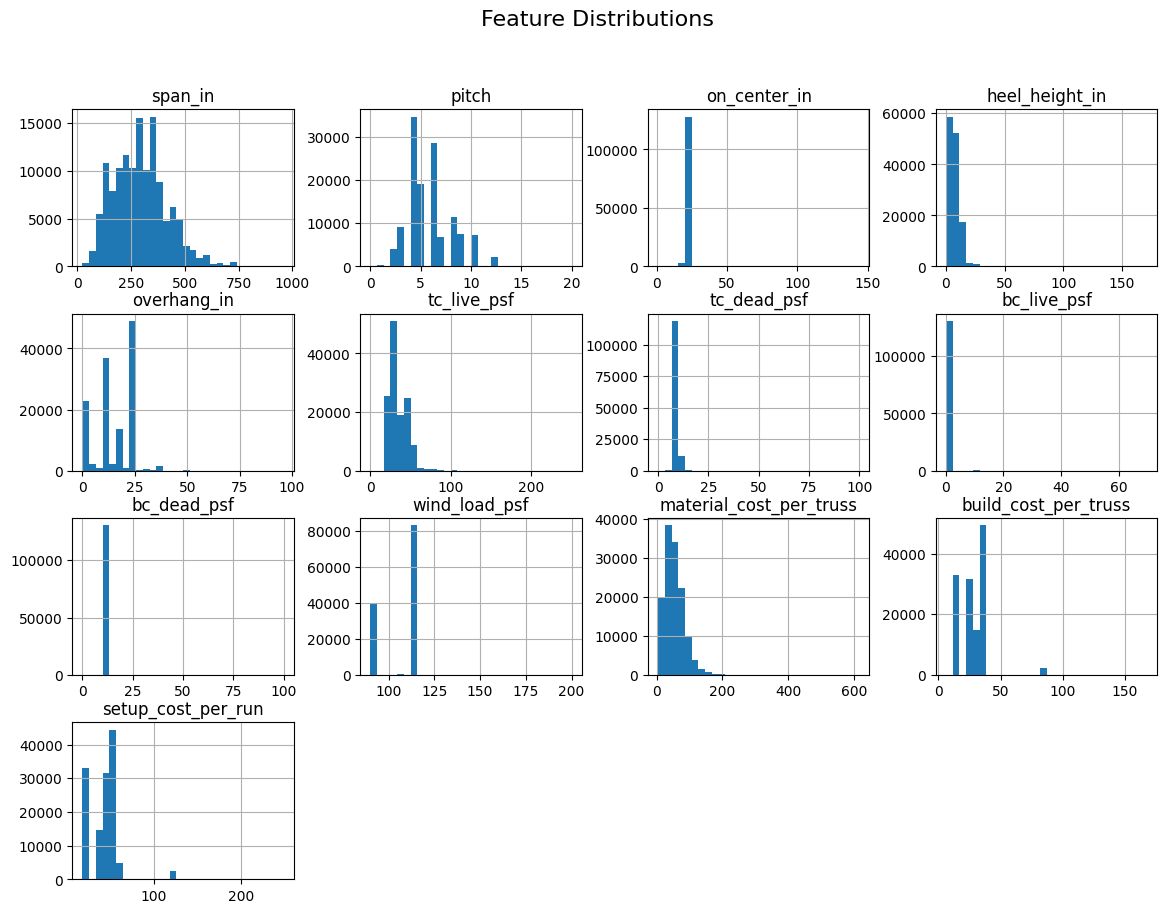

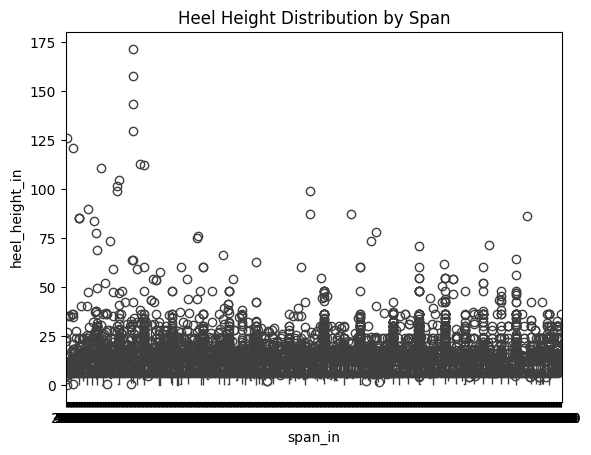

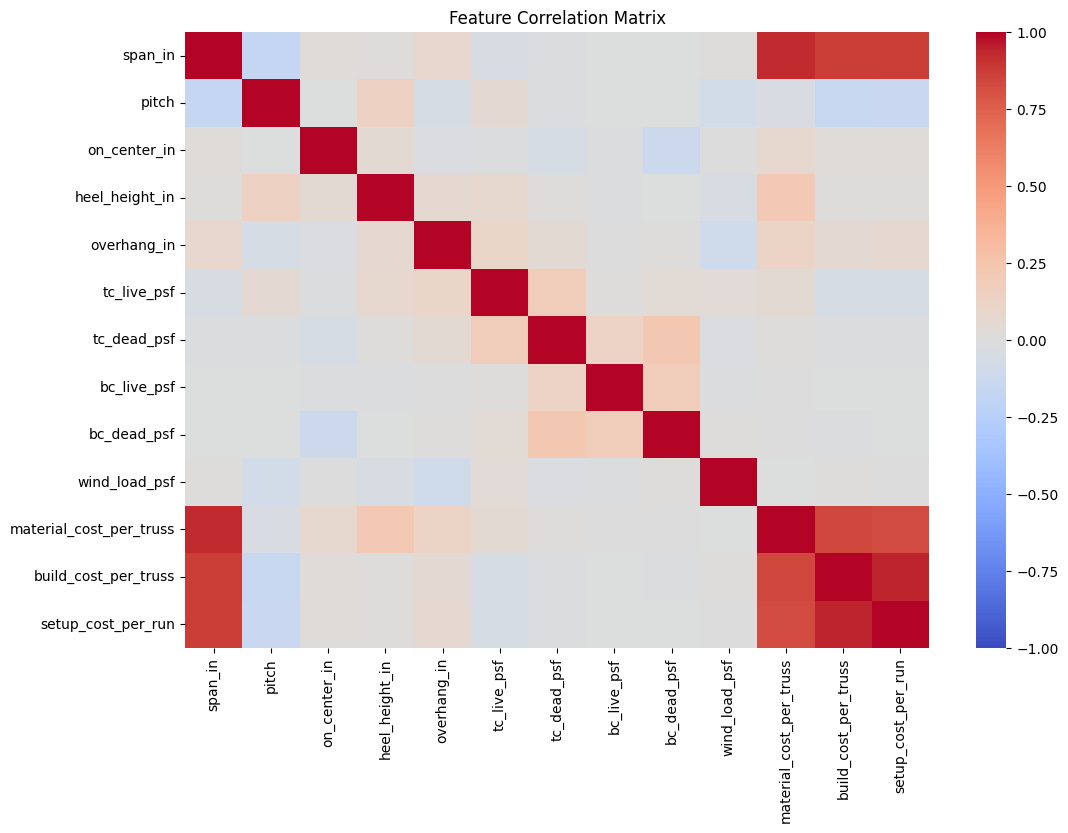

🔍 Basic Info:
Rows: 131,194, Columns: 13
Missing values: 8,295
Duplicate rows: 0

📊 Missingness (% of rows):


wind_load_psf     6.32
span_in           0.00
pitch             0.00
on_center_in      0.00
heel_height_in    0.00
overhang_in       0.00
tc_live_psf       0.00
tc_dead_psf       0.00
bc_live_psf       0.00
bc_dead_psf       0.00
dtype: float64


📏 span_in Frequency:
span_in
24.0     14
36.0     28
42.0     11
44.0     11
48.0    224
52.0     15
54.0     24
56.0     18
59.0     14
60.0    238
63.0     11
64.0     20
65.0     16
66.0     35
67.0     10
Name: count, dtype: int64


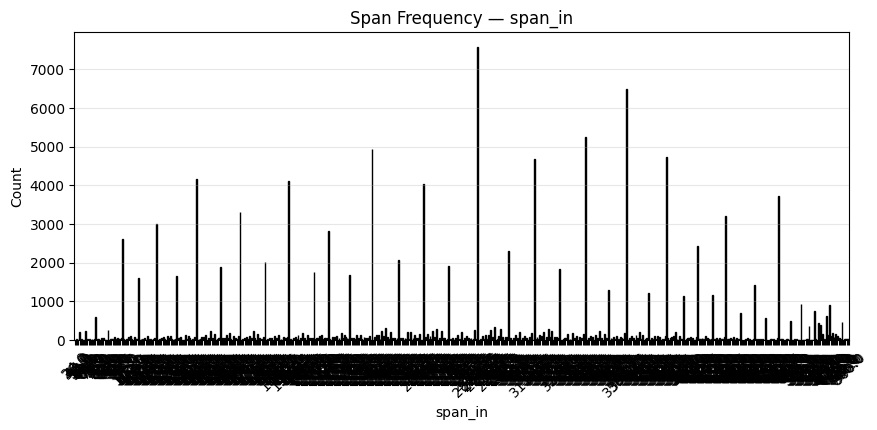


📈 Numeric Feature Summary:


,count,mean,std,min,25%,50%,75%,max
span_in,131194.0,292.11,122.48,24.00,192.00,288.00,360.00,960.00
material_cost_per_truss,131194.0,54.50,29.33,4.71,34.04,48.92,70.47,617.17
setup_cost_per_run,131194.0,41.24,18.21,17.85,18.28,45.43,49.86,249.30
build_cost_per_truss,131194.0,27.09,11.96,6.02,13.85,27.70,33.24,167.86
wind_load_psf,122899.0,106.99,11.68,90.00,90.00,115.00,115.00,200.00
tc_live_psf,131194.0,32.89,10.69,0.00,25.00,30.00,42.00,250.00
overhang_in,131194.0,15.33,9.13,0.00,12.00,16.00,24.00,96.00
heel_height_in,131194.0,6.95,4.17,0.00,4.06,6.06,7.50,171.44
on_center_in,131194.0,23.91,2.43,1.00,24.00,24.00,24.00,144.00
pitch,131194.0,5.72,2.18,0.00,4.00,5.00,7.00,20.00


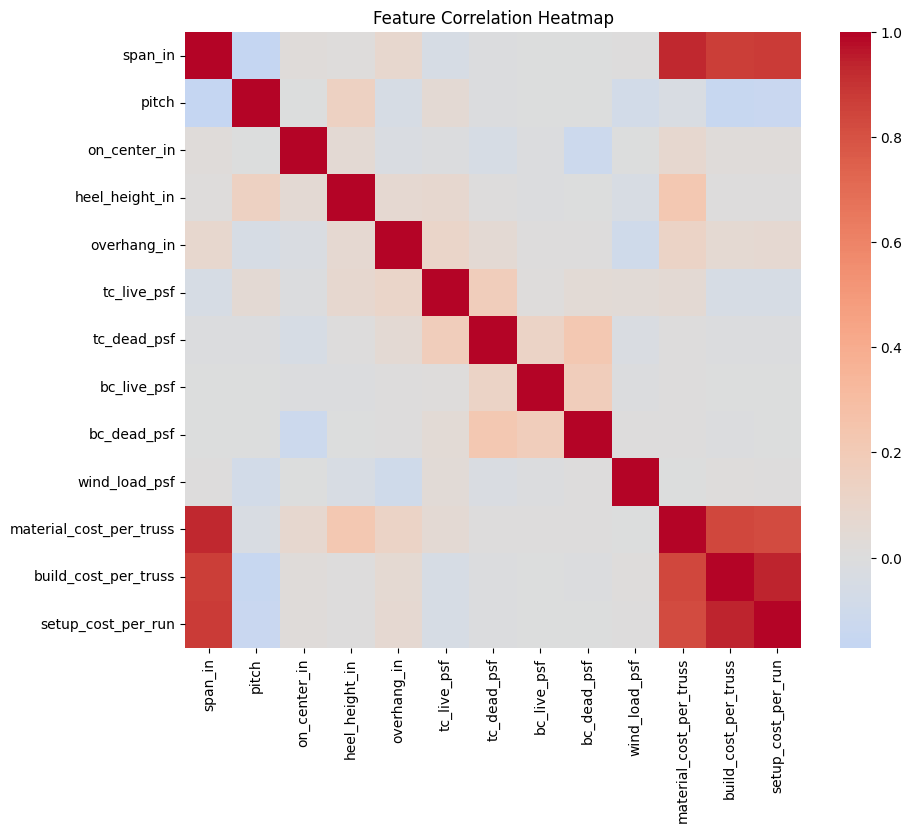


🔗 Top 15 features correlated with material_cost_per_truss:


,Correlation
material_cost_per_truss,1.000000
span_in,0.928419
build_cost_per_truss,0.837346
setup_cost_per_run,0.825779
heel_height_in,0.218223
overhang_in,0.122833
on_center_in,0.077615
tc_live_psf,0.049260
pitch,0.031868
tc_dead_psf,0.011327



📊 Example Feature Distributions:


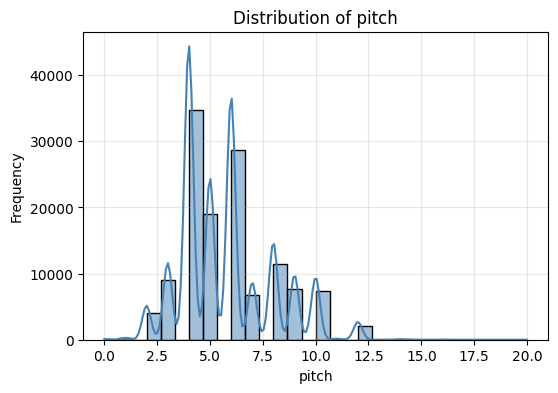

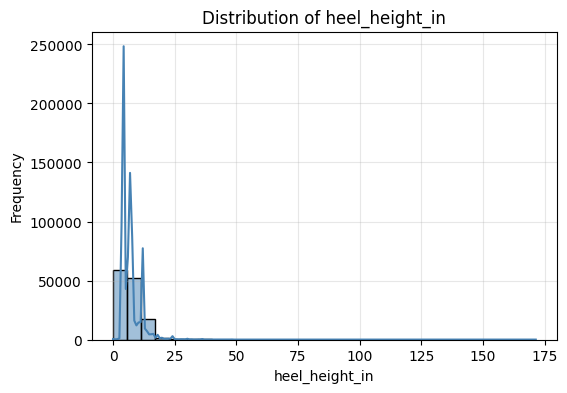

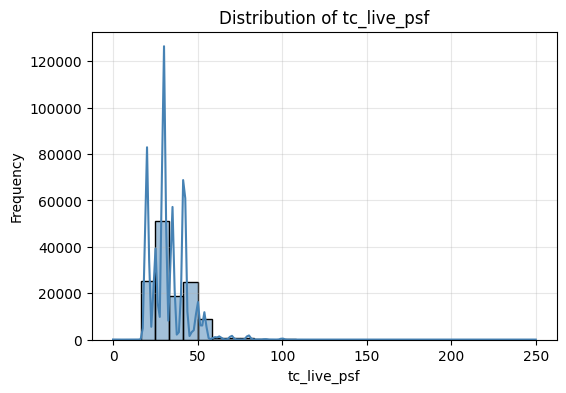

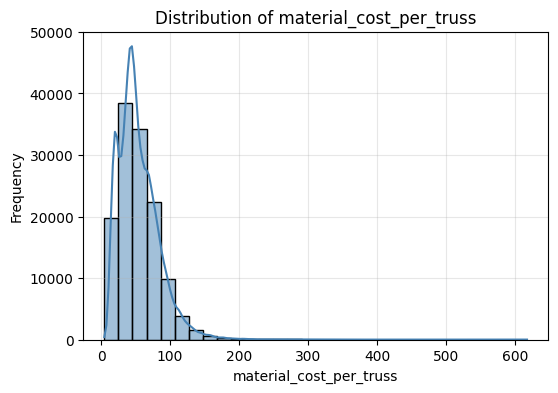


✅ Diagnostics complete.


In [21]:
data.describe().T.sort_values("std", ascending=False)
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols].hist(figsize=(14, 10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

sns.boxplot(data=data, x="span_in", y="heel_height_in")
plt.title("Heel Height Distribution by Span")
plt.show()

corr = data.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

quick_data_diagnostics(data, target_col="material_cost_per_truss", group_col="span_in")


